In this notebook we are creating an auto encoder for anomaly detection of time series (here ECG). We are going to use a basic autoencoder , a pytorch variational autoencoder and a pyro variational auto encoder.

The dataset is composed of a list of heartbeat from a single patient (http://timeseriesclassification.com/description.php?Dataset=ECG5000), some being labelled normal and some other being labeled abnormal. We are going to train an autoencoder on normal heartbeat so we can find a lower dimensional representation of the normal heartbeat ecg recording. On that lower dimensional representation it will be easier to spot abnormal heartbeat as they should stand in some very different place on that latent space compare to the normal heartbeat, and the model should have a harder time to represent them. So by choosing a threshold on what we consider a good representation or not we should be able to identify heartbeat that doesn't ressemble normal heartbeat. 

The data are timeseries so the encoder and decoders will be made of LSTM.

The data set, a part of of the data preprocessing and the simple autoencoder part is highly inspired from https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/. The variational autoencoder with pytorch is highly inspired by , and the pyro autoencoder by https://pyro.ai/examples/vae.html

### The goal here is not ot present what is behind an autoencoder. 

A great article to understand the concepts of an AE is https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73. I highly highly recomend you go take a look before going through this pile of code.

I always thought that the way the different loss function are brought is not really straightforward. A better understanding for me of those loss function can be found as forum answers from : https://stats.stackexchange.com/questions/304289/variational-autoencoder-understanding-the-latent-loss and https://stats.stackexchange.com/questions/304146/explanation-needed-for-vae-latence-space-cost-term/305610#305610

# Preprocessing

In [1]:
from arff2pandas import a2p#you will need that for the reading of the ecg format file
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import copy

In [2]:
import torch#; torch.manual_seed(42)

import torch.nn.functional as F
import torch.utils
import torch.distributions

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
with open('ECG5000/ECG5000_TRAIN.arff') as f:
    train = a2p.load(f)
with open('ECG5000/ECG5000_TEST.arff') as f:
    test = a2p.load(f)

In [5]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [6]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

In [7]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [8]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [9]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=42
)
val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=42
)


In [10]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).numpy() for s in sequences]
    n_seq, seq_len, n_features = np.stack(dataset).shape
    return dataset, seq_len, n_features

In [11]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [12]:
from torch.utils.data import Dataset
class ECG_dataset(Dataset):
    def __init__(self,sequences,targets):
        self.sequences=sequences
        self.targets=targets
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, item):
        sequence=self.sequences[item]
        target=int(self.targets[item])
        return {'sequence': torch.tensor(sequence, dtype=torch.float32),
                'target': torch.tensor(target, dtype=torch.long)
               }

In [13]:

i_train_dataset = ECG_dataset(sequences=train_dataset,targets=[0 for i in range(len(train_dataset))])

i_train_data_loader = torch.utils.data.DataLoader(i_train_dataset,batch_size=128,num_workers=16)

i_val_dataset = ECG_dataset(sequences=val_dataset,targets=[0 for i in range(len(val_dataset))])

i_val_data_loader = torch.utils.data.DataLoader(i_val_dataset,batch_size=128,num_workers=16)

# Pytorch AE

In [61]:
class EncoderAE(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(EncoderAE, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )
    def forward(self, x):
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        #by using hidden_n I am restraining myself to the last hidden state of the time serie, whereas x is the
        #time serie of hidden states. The last hidden state is what we want because we want the latent space
        #representation where a time serie is just a point in this space not a time serie of point anymore.
        return hidden_n.permute(1,0,2)#we need to permute the hidden so it has the right form to feed an LSTM.
    # Check the documentation to see why, it is pretty simple

In [62]:
class DecoderAE(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(DecoderAE, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
            input_size=self.input_dim,
          hidden_size=self.input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    def forward(self, x):#x is a tensor of single point representing a time serie in a latent space,
        #but rnn need a time serie, so we use repeat to create a serie of those repeated single point
        x = torch.stack([x1.repeat(self.seq_len, self.n_features)for x1 in x])
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        return self.output_layer(x)

In [67]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = EncoderAE(seq_len, n_features, embedding_dim).to(device)
        self.decoder = DecoderAE(seq_len, embedding_dim, n_features).to(device)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [69]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='mean').to(device)# You just want to minimize the distance between ground truth
    # and encoded-small dimensionality space-decoded(ground truth). To me at least the L2 loss makes more sense.
    # Indeed later on, using the variational principle with an assumption on the Gaussian form of the decoder
    # the L2 loss appears by itself... But ok.
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        train_losses = []
        for d in train_dataset:
            seq_true=d['sequence']
            optimizer.zero_grad()
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for d in val_dataset:
                seq_true=d['sequence']
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [70]:
model, history = train_model(
  model,
  i_train_data_loader,
  i_val_data_loader,
  n_epochs=500
)

Epoch 1: train loss 0.6671505451202393 val loss 0.682275672753652
Epoch 2: train loss 0.670145782828331 val loss 0.6690489451090494
Epoch 3: train loss 0.6659453809261322 val loss 0.6677653392155966
Epoch 9: train loss 0.6646840006113053 val loss 0.6635116338729858
Epoch 10: train loss 0.6511185467243195 val loss 0.6546155015627543
Epoch 11: train loss 0.6401678800582886 val loss 0.6483821670214335
Epoch 12: train loss 0.6433427900075912 val loss 0.6171697576840719
Epoch 15: train loss 0.6175350069999694 val loss 0.5842268069585165
Epoch 19: train loss 0.5745822101831436 val loss 0.5376350482304891
Epoch 23: train loss 0.5365414291620254 val loss 0.534193754196167
Epoch 24: train loss 0.4635530263185501 val loss 0.44022268056869507
Epoch 25: train loss 0.40828815549612046 val loss 0.42859041690826416
Epoch 26: train loss 0.39751633554697036 val loss 0.4216228425502777
Epoch 27: train loss 0.387586373090744 val loss 0.40732984741528827
Epoch 31: train loss 0.38335591852664946 val loss 0

In [71]:
def loss_plot(loss_train,loss_val):
    fig=plt.figure(figsize=(5,5))
    plt.plot(np.arange(len(loss_train)),loss_train,'b',label='train')
    plt.plot(np.arange(len(loss_val)),loss_val,'r',label='val')
    plt.legend(loc='best')
    plt.xlabel('epochs')
    plt.ylabel('L1 loss')
    plt.show()

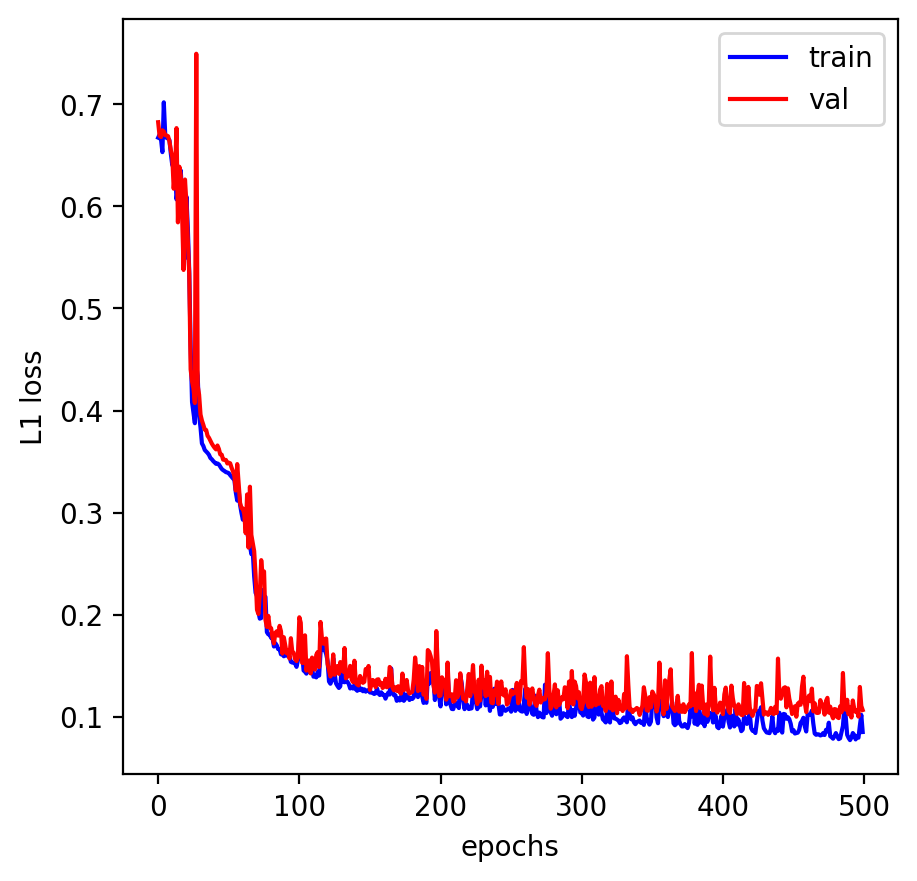

In [72]:
loss_plot(history['train'],history['val'])

In [36]:
MODEL_PATH = 'model_AE_ECG_epochs_500_latentdim_128.pth'
torch.save(model, MODEL_PATH)

In [14]:
#just concatenate everything: train val,test, abnormal ,normal
df_n_a=pd.concat([normal_df,anomaly_df])
df_n_a

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC
242,-1.018422,-2.521015,-3.532577,-3.940422,-3.811764,-3.532028,-3.083290,-2.105920,-1.369005,-1.238763,...,1.050033,0.499702,-0.155624,-0.873284,-1.275818,-1.571572,-1.310301,-0.759625,-0.785927,-1.809209
2019,-1.644921,-2.409708,-3.279804,-3.825820,-4.099372,-3.825975,-3.345044,-2.272802,-1.737734,-1.522103,...,0.986840,0.942096,0.988068,0.773729,0.361819,-0.040981,-0.122264,0.171462,-0.151763,-0.918836
1313,-1.411248,-2.865195,-3.439481,-3.805908,-3.736798,-3.309542,-2.270266,-1.589111,-1.431828,-0.814029,...,1.513967,1.773485,1.217994,0.242877,-0.685669,-1.403270,-1.574741,-1.207814,-0.293961,-0.455340
536,0.002810,-0.557572,-1.261317,-2.304053,-2.879768,-3.495573,-3.100459,-2.227161,-1.832312,-1.610649,...,1.105344,1.552653,2.075931,2.057462,2.195938,2.117290,2.004904,1.407775,1.276158,1.530415
2512,-0.001779,-2.133092,-3.487498,-3.825727,-3.599374,-3.139405,-2.212227,-1.708759,-1.576434,-1.024729,...,1.169322,1.265019,1.312462,1.570994,1.622535,1.421387,1.358417,1.571143,2.182116,1.083809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,0.809937,-0.086718,-1.072085,-1.984429,-2.694535,-3.097029,-2.989874,-2.619655,-2.008892,-1.448949,...,-1.303451,-1.871187,-2.594050,-3.442055,-3.957798,-3.374311,-2.584303,-1.411106,-1.168106,-0.660048
3837,0.628679,0.028869,-0.859949,-1.673728,-2.158767,-2.162289,-1.884152,-1.481326,-1.111792,-0.870569,...,0.464694,0.046910,-0.293809,-0.558404,-1.321585,-2.354039,-2.746197,-2.861460,-2.670841,-2.342160
3300,0.927570,-0.367651,-1.407037,-2.494874,-3.305764,-3.457782,-3.209052,-2.846324,-2.370664,-1.797530,...,-1.664230,-1.997820,-2.414725,-2.869351,-3.084215,-2.569603,-1.672457,-0.510052,0.230944,0.960471
3507,-0.771630,-2.232628,-3.152674,-3.581292,-3.378039,-3.094399,-2.536773,-1.748678,-1.042883,-0.975582,...,-0.463596,-1.170622,-1.515581,-2.103121,-2.825158,-3.409660,-3.322502,-2.464701,-1.016952,0.185271


In [15]:
_dataset, _, _ = create_dataset(df_n_a)
i_dataset = ECG_dataset(sequences=_dataset,targets=[0 for i in range(len(normal_df))]+[1 for i in range(len(anomaly_df))])

i_data_loader = torch.utils.data.DataLoader(i_dataset,batch_size=128,num_workers=16)

In [77]:
import umap.umap_ as umap

def plot_latent_ea(autoencoder, data,nei):
    stack=[]
    stacky=[]
    for i, d in enumerate(data):
        x=d['sequence']
        y=d['target'].to('cpu').detach().numpy().tolist()
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        stack.extend([x[0] for x in z])
        stacky.extend(y)
    
    umaper = umap.UMAP(n_components=2,n_neighbors=nei)
    x_umap = umaper.fit_transform(stack)
    sc=plt.scatter(x_umap[:, 0], x_umap[:, 1],s=2, c=stacky, cmap='RdBu')
    cb = plt.colorbar(sc,ticks=np.arange(0,2,1))
    cb.ax.tick_params(labelsize=9)
    cb.ax.set_yticklabels(['Normal','Abnormal'])
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()
            

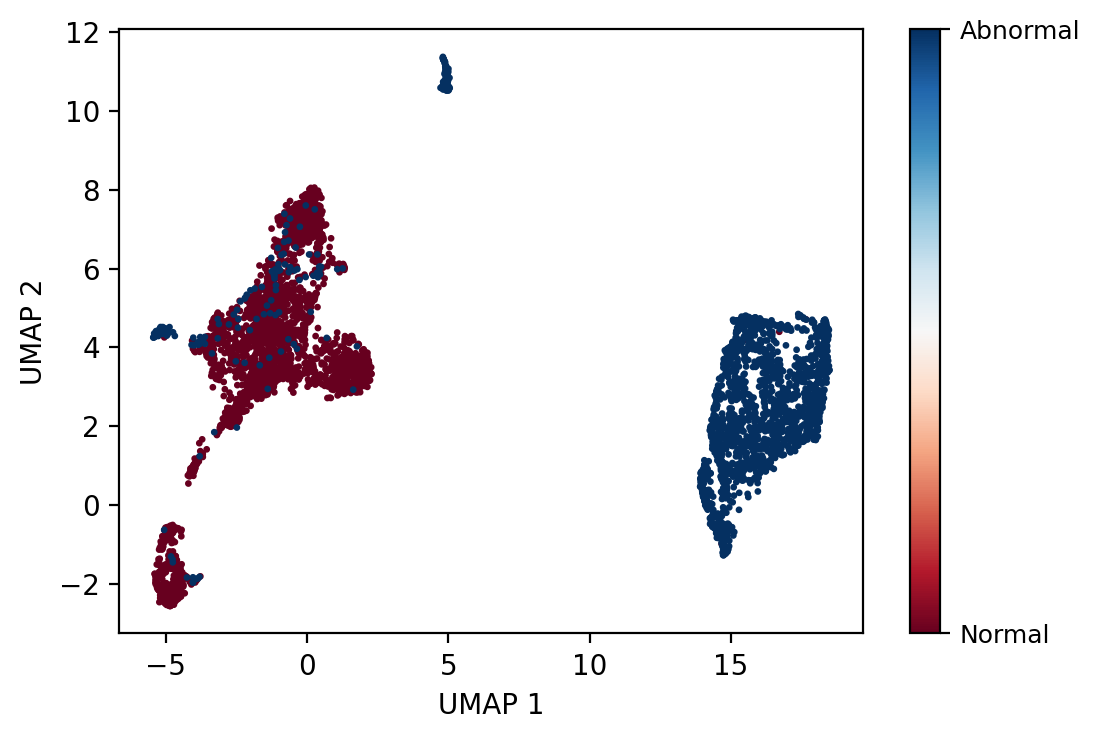

In [78]:
plot_latent_ea(model, i_data_loader,100)

The main part of the abnormal ECG seats away from the normal  ecg in the latent space! So from there we could either use our arsenal of classification technics if we have enought and comparable numbers of abnormal vs normal. We could also check the loss function output and put a threshold on that L1 loss : indeed the abnormal ecg should have a higher loss than normal ecg since the model has never seen them and is train to fit a subclass of ecg from which the abormal are not part. This is to me the best thing to do when your anomalies are rare and you can not use usual technics : by doing so you just set what you think is good enought as a false positive rate.

In some publication I have seen people use one class SVM to draw the countours of the non anomaly point. It is also a good option since it is unsupervised and thus would work nicely in the case where you don't have access to rare event anomaly. The problem is that you will have to deal with quite a few hyper parameters but you don't have a validation (or even a training by the way) set to use (if you had you would be using classification technics). So you could instead choose the hyper parameters in relation to the false positive rate too...

I 'll try some of those options another day.

# Pytorch VAE

In [79]:
class EncoderVAE(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(EncoderVAE, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )
        self.rnn3 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )
    def forward(self, x):
        
        x, (_, _) = self.rnn1(x)
        x1, (hidden_n_mu, _) = self.rnn2(x)
        x2, (hidden_n_sigma, _) = self.rnn2(x)
        og_mu=hidden_n_mu.permute(1,0,2)
        og_sigma=torch.exp(hidden_n_sigma.permute(1,0,2))
        
        z = og_mu + og_sigma*self.N.sample(og_mu.shape)#reparametrization trick
        self.kl = (og_sigma**2 + og_mu**2 - torch.log(og_sigma) - 1/2).mean()#analytical solution for the 
        #KL divergence between a gaussian distributed aproximate encoder and the prior distribution of our latent
        #variable that we set to be normal.
        return z
    
    
    
class DecoderVAE(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(DecoderVAE, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
            input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    def forward(self, x):
        x = torch.stack([x1.repeat(self.seq_len, self.n_features)for x1 in x])
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        return self.output_layer(x)    

In [80]:
class RecurrentVariationalAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentVariationalAutoencoder, self).__init__()
        self.encoder = EncoderVAE(seq_len, n_features, embedding_dim).to(device)
        self.decoder = DecoderVAE(seq_len, embedding_dim, n_features).to(device)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [81]:
variational_model = RecurrentVariationalAutoencoder(seq_len, n_features, 128)
variational_model = variational_model.to(device)

/home/seb/anaconda3/envs/base_py39/lib/python3.9/site-packages/torch/backends/cudnn/__init__.py:73: UserWarning: PyTorch was compiled without cuDNN/MIOpen support. To use cuDNN/MIOpen, rebuild PyTorch making sure the library is visible to the build system.
  warnings.warn(


In [82]:
def train_variational_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='mean').to(device)#Check L2
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        train_losses = []
        for d in train_dataset:
            seq_true=d['sequence']
            optimizer.zero_grad()
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)+ model.encoder.kl# kind of ELBO loss : you recognize the l1 loss and the KL divergence
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for d in val_dataset:
                seq_true=d['sequence']
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                loss = criterion(seq_pred, seq_true)+ model.encoder.kl
                val_losses.append(loss.item())
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [83]:
variational_model, variational_history = train_variational_model(
  variational_model,
  i_train_data_loader,
  i_val_data_loader,
  n_epochs=500
)

Epoch 1: train loss 1.088166019320488 val loss 1.0187259912490845
Epoch 2: train loss 0.9835638493299484 val loss 1.000169575214386
Epoch 3: train loss 0.9664379388093949 val loss 0.9750319321950277
Epoch 4: train loss 0.9332068234682083 val loss 0.940691351890564
Epoch 6: train loss 0.9187839329242706 val loss 0.9362931648890177
Epoch 7: train loss 0.9141664266586303 val loss 0.9318819840749105
Epoch 8: train loss 0.9105441749095917 val loss 0.9225001335144043
Epoch 9: train loss 0.86986024081707 val loss 0.8745956420898438
Epoch 10: train loss 0.8237154453992843 val loss 0.8474923570950826
Epoch 11: train loss 0.8136575907468796 val loss 0.8363152941068014
Epoch 12: train loss 0.8056078910827636 val loss 0.8304487268129984
Epoch 14: train loss 0.8021927684545517 val loss 0.827327291170756
Epoch 15: train loss 0.7996798187494278 val loss 0.8261704246203104
Epoch 18: train loss 0.7984049111604691 val loss 0.8259462912877401
Epoch 19: train loss 0.7975610345602036 val loss 0.82593107223

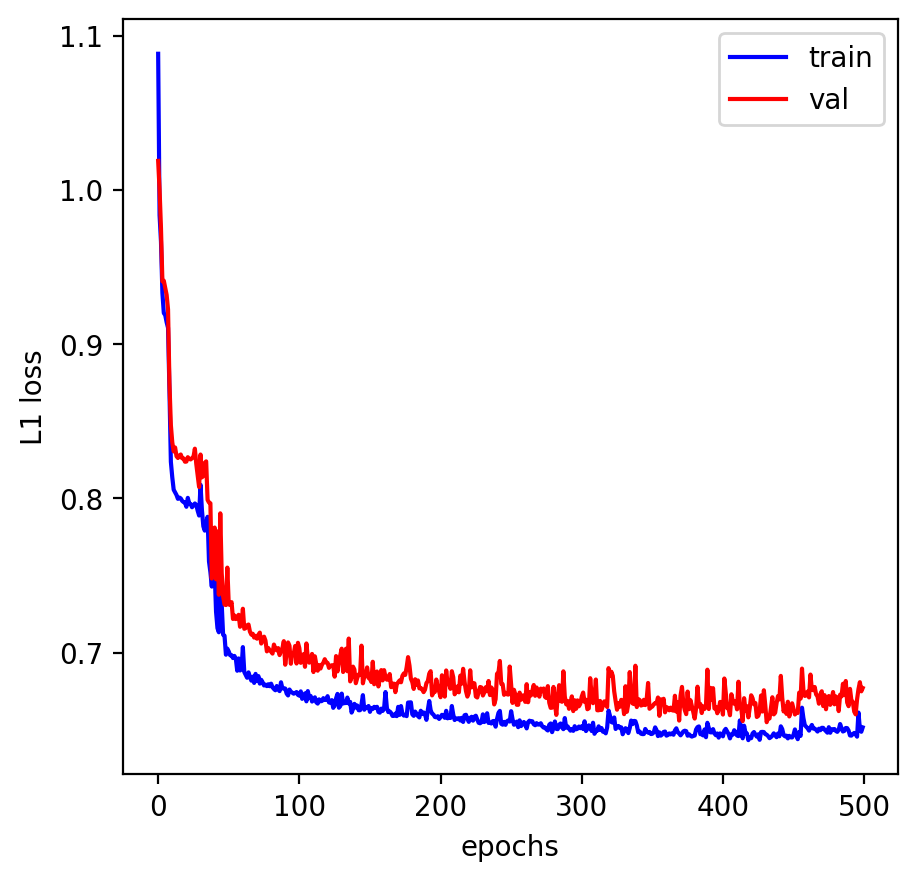

In [84]:
loss_plot(variational_history['train'],variational_history['val'])

In [85]:
MODEL_PATH = 'model_VAE_ECG_epochs_500_latentdim_128.pth'
torch.save(variational_model, MODEL_PATH)

In [86]:
def plot_latent_vea(autoencoder, data,nei):
    stack=[]
    stacky=[]
    for i, d in enumerate(data):
        x=d['sequence']
        y=d['target'].to('cpu').detach().numpy().tolist()
        kee=[]
        for k in range(100):#the econder is stochastic so we draw 100 time to calculate/ represent the mean
            z = autoencoder.encoder(x.to(device))
            z = z.to('cpu').detach().numpy()
            kee.append([r[0] for r in z])
        kee=np.array(kee)
        z = kee.mean(axis=0).tolist()
        stack.extend(z)
        stacky.extend(y)
    
    umaper = umap.UMAP(n_components=2,n_neighbors=nei)
    x_umap = umaper.fit_transform(stack)
    sc=plt.scatter(x_umap[:, 0], x_umap[:, 1],s=2, c=stacky, cmap='RdBu')
    cb = plt.colorbar(sc,ticks=np.arange(0,2,1))
    cb.ax.tick_params(labelsize=9)
    cb.ax.set_yticklabels(['Normal','Abnormal'])
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

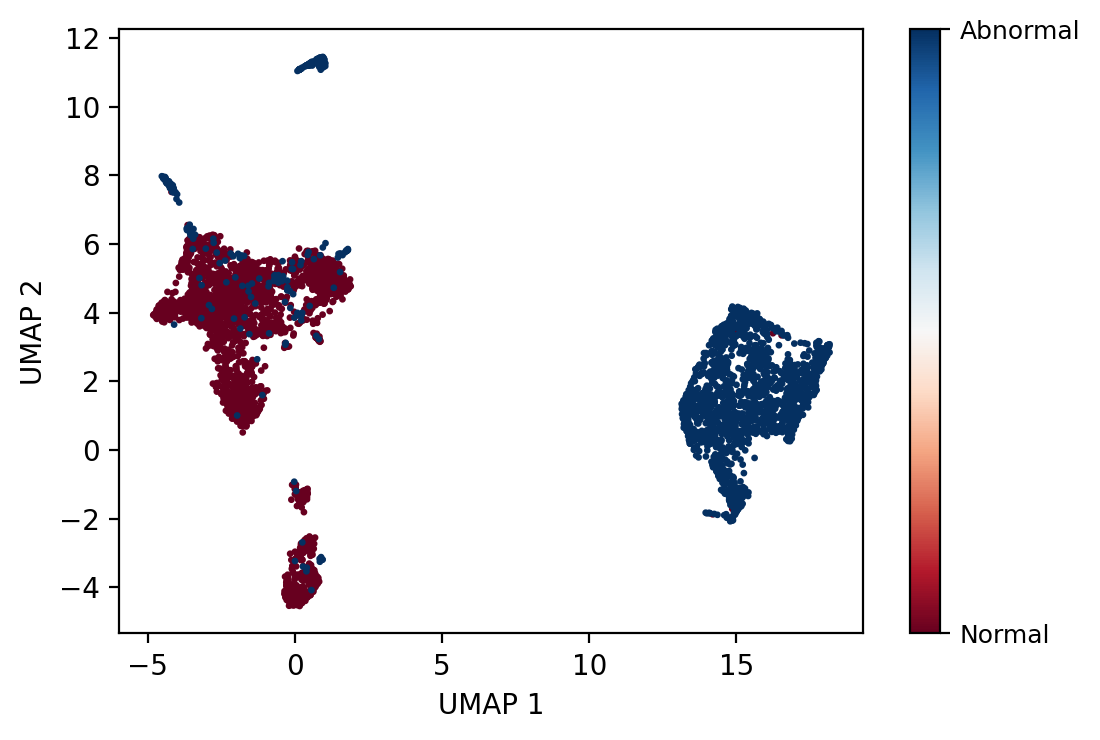

In [87]:
plot_latent_vea(model, i_data_loader,100)

# Pyro VAE

In [88]:
import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from torch.distributions import constraints

In [89]:
class EncoderPyroVAE(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(EncoderPyroVAE, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        
        
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )
        self.rnn3 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )
    def forward(self, x):
        x, (_, _) = self.rnn1(x)
        x1, (hidden_n_mu, _) = self.rnn2(x)
        x2, (hidden_n_sigma, _) = self.rnn2(x)

        z_loc=hidden_n_mu.permute(1,0,2)
        z_scale=torch.exp(hidden_n_sigma.permute(1,0,2))
        
        
        return z_loc.squeeze(),z_scale.squeeze()#I need to squeeze to get rid to the extra dimension of my data.
    #This extra dimension is linked to how our x is defined : each point in x as a single feature. This
    #dimension is dragued till this end but pyro doesn't get it so I had to squeeze.
    
    
    
class DecoderPyroVAE(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(DecoderPyroVAE, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
            input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    def forward(self, x):
        x = torch.stack([x1.repeat(self.seq_len, self.n_features)for x1 in x])
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = self.output_layer(x)
        return x

    


        
class PyroVAE(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64,use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = EncoderPyroVAE(seq_len, n_features, embedding_dim)
        self.decoder = DecoderPyroVAE(seq_len, embedding_dim, n_features)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = embedding_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        #sigma = pyro.sample("sigma",dist.HalfCauchy(0.1))
        sigma = pyro.param("sigma", torch.tensor([0.4]), constraint=constraints.positive)
        # we are going to fit our data with a normal distribution (very approximate here...)
        #(see that as the maxlieklihood part of our loss : before we were using L1 or L2 now
        # since we are using distribution we use maxlikelihood)
        # that will be centered around the output of our decoder on a specific region of the latent space
        # that will be sampled according of the encoder results... The sigma of that normal distribution
        # if found to maximize likelihood
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0],self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0],self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_ecg = self.decoder(z)
            
            # score against actual ecg (log likelihood)
            pyro.sample("obs", dist.Normal(loc_ecg.squeeze(),sigma.to(device)).to_event(1), obs=x.squeeze())


    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
    # we will need a reconstruct to actually check how our algo generalize
    # Indeed we can not evaluate the ELBO loss on a validation test.... SO we are going to use L1 or 2
    def reconstruct_ecg(self, x):
        # encode ecg x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the ecg
        loc_ecg = self.decoder(z)
        return loc_ecg

In [92]:
def train_pyroVAE_better(svi, model,train_loader,val_loader, use_cuda=False):
    # initialize loss accumulator
    criterion = nn.L1Loss(reduction='mean').to(device)#Check L2
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for d in train_loader:
        # if on GPU put mini-batch into CUDA memory
        x=d['sequence']
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)
    val_losses = []
    train_losses = []
    #not sure you need any of those eval and torch.no_grad(). Let's check the l1 loss for our training and eval
    model = model.eval()
    with torch.no_grad():
        for d in train_loader:
            seq_true=d['sequence']
            seq_true = seq_true.to(device)
            seq_pred = model.reconstruct_ecg(seq_true)
            loss = criterion(seq_pred, seq_true)
            train_losses.append(loss.item())
        for d in val_loader:
            seq_true=d['sequence']
            seq_true = seq_true.to(device)
            seq_pred = model.reconstruct_ecg(seq_true)
            loss = criterion(seq_pred, seq_true)
            val_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train,train_loss,val_loss

In [94]:
LEARNING_RATE = 1.0e-3
USE_CUDA = True

# Run only for a single iteration for testing
NUM_EPOCHS = 500


pyro.clear_param_store()

# setup the VAE
pyrovae = PyroVAE(seq_len, n_features, 128,use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(pyrovae.model, pyrovae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
val_l1_list = []
train_l1_list = []
pyro.clear_param_store()
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train,train_l1,val_l1 = train_pyroVAE_better(svi, pyrovae,i_train_data_loader,i_val_data_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    train_l1_list.append(train_l1)
    val_l1_list.append(val_l1)
    print("[epoch %03d]  average training ELBO loss: %.4f, average training l1 loss: %.4f average val loss: %.4f" % (epoch, total_epoch_loss_train,train_l1,val_l1))

[epoch 000]  average training ELBO loss: 404.9186, average training l1 loss: 0.6305 average val loss: 0.6349
[epoch 001]  average training ELBO loss: 301.6151, average training l1 loss: 0.5473 average val loss: 0.5565
[epoch 002]  average training ELBO loss: 205.8961, average training l1 loss: 0.5220 average val loss: 0.5402
[epoch 003]  average training ELBO loss: 175.0736, average training l1 loss: 0.4527 average val loss: 0.4755
[epoch 004]  average training ELBO loss: 166.9541, average training l1 loss: 0.4056 average val loss: 0.4301
[epoch 005]  average training ELBO loss: 145.9277, average training l1 loss: 0.4059 average val loss: 0.4310
[epoch 006]  average training ELBO loss: 143.4480, average training l1 loss: 0.3938 average val loss: 0.4223
[epoch 007]  average training ELBO loss: 140.7891, average training l1 loss: 0.3922 average val loss: 0.4157
[epoch 008]  average training ELBO loss: 138.7778, average training l1 loss: 0.3977 average val loss: 0.4234
[epoch 009]  averag

[epoch 076]  average training ELBO loss: 80.7100, average training l1 loss: 0.2575 average val loss: 0.2758
[epoch 077]  average training ELBO loss: 80.5578, average training l1 loss: 0.2922 average val loss: 0.3050
[epoch 078]  average training ELBO loss: 90.3229, average training l1 loss: 0.2876 average val loss: 0.2974
[epoch 079]  average training ELBO loss: 83.0908, average training l1 loss: 0.2924 average val loss: 0.3120
[epoch 080]  average training ELBO loss: 79.4581, average training l1 loss: 0.2519 average val loss: 0.2639
[epoch 081]  average training ELBO loss: 78.1236, average training l1 loss: 0.2438 average val loss: 0.2615
[epoch 082]  average training ELBO loss: 78.3425, average training l1 loss: 0.2470 average val loss: 0.2643
[epoch 083]  average training ELBO loss: 76.0002, average training l1 loss: 0.2629 average val loss: 0.2742
[epoch 084]  average training ELBO loss: 77.5331, average training l1 loss: 0.2802 average val loss: 0.2918
[epoch 085]  average trainin

[epoch 152]  average training ELBO loss: 42.0149, average training l1 loss: 0.1866 average val loss: 0.1979
[epoch 153]  average training ELBO loss: 44.9707, average training l1 loss: 0.1869 average val loss: 0.1947
[epoch 154]  average training ELBO loss: 45.4097, average training l1 loss: 0.1854 average val loss: 0.1944
[epoch 155]  average training ELBO loss: 42.2879, average training l1 loss: 0.1847 average val loss: 0.1940
[epoch 156]  average training ELBO loss: 42.5892, average training l1 loss: 0.1984 average val loss: 0.2101
[epoch 157]  average training ELBO loss: 53.8254, average training l1 loss: 0.1872 average val loss: 0.1958
[epoch 158]  average training ELBO loss: 43.4950, average training l1 loss: 0.2076 average val loss: 0.2144
[epoch 159]  average training ELBO loss: 50.1298, average training l1 loss: 0.2066 average val loss: 0.2127
[epoch 160]  average training ELBO loss: 50.1449, average training l1 loss: 0.1992 average val loss: 0.2056
[epoch 161]  average trainin

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/seb/anaconda3/envs/base_py39/lib/python3.9/multiprocessing/queues.py", line 241, in _feed
    close()
  File "/home/seb/anaconda3/envs/base_py39/lib/python3.9/multiprocessing/connection.py", line 182, in close
    self._close()
  File "/home/seb/anaconda3/envs/base_py39/lib/python3.9/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/seb/anaconda3/envs/base_py39/lib/python3.9/threading.py", line 950, in _bootstrap_inner
    self.run()
  File "/home/seb/anaconda3/envs/base_py39/lib/python3.9/threading.py", line 888, in run
    self._target(*self._args, **self._kwargs)
  File "/home/seb/anaconda3/envs/base_py39/lib/python3.9/multiprocessing/queues.py", line 272, in _feed
    queue_sem.release()
ValueError: semaphore or l

[epoch 164]  average training ELBO loss: 61.7117, average training l1 loss: 0.2811 average val loss: 0.2889
[epoch 165]  average training ELBO loss: 67.5354, average training l1 loss: 0.2219 average val loss: 0.2311
[epoch 166]  average training ELBO loss: 50.1577, average training l1 loss: 0.2102 average val loss: 0.2170
[epoch 167]  average training ELBO loss: 46.4543, average training l1 loss: 0.1857 average val loss: 0.1991
[epoch 168]  average training ELBO loss: 40.7535, average training l1 loss: 0.1859 average val loss: 0.1965
[epoch 169]  average training ELBO loss: 39.3703, average training l1 loss: 0.1854 average val loss: 0.1984
[epoch 170]  average training ELBO loss: 40.1751, average training l1 loss: 0.1856 average val loss: 0.1977
[epoch 171]  average training ELBO loss: 40.5069, average training l1 loss: 0.1903 average val loss: 0.1994
[epoch 172]  average training ELBO loss: 41.2221, average training l1 loss: 0.1915 average val loss: 0.1987
[epoch 173]  average trainin

[epoch 240]  average training ELBO loss: 32.0439, average training l1 loss: 0.1725 average val loss: 0.1791
[epoch 241]  average training ELBO loss: 30.5110, average training l1 loss: 0.1699 average val loss: 0.1773
[epoch 242]  average training ELBO loss: 40.2183, average training l1 loss: 0.2080 average val loss: 0.2099
[epoch 243]  average training ELBO loss: 42.2451, average training l1 loss: 0.1838 average val loss: 0.1932
[epoch 244]  average training ELBO loss: 33.4094, average training l1 loss: 0.1906 average val loss: 0.2028
[epoch 245]  average training ELBO loss: 46.6863, average training l1 loss: 0.1933 average val loss: 0.2057
[epoch 246]  average training ELBO loss: 36.4951, average training l1 loss: 0.1699 average val loss: 0.1807
[epoch 247]  average training ELBO loss: 30.8219, average training l1 loss: 0.1877 average val loss: 0.1979
[epoch 248]  average training ELBO loss: 46.9638, average training l1 loss: 0.2033 average val loss: 0.2092
[epoch 249]  average trainin

[epoch 316]  average training ELBO loss: 29.0278, average training l1 loss: 0.1626 average val loss: 0.1703
[epoch 317]  average training ELBO loss: 24.8694, average training l1 loss: 0.1632 average val loss: 0.1696
[epoch 318]  average training ELBO loss: 32.4834, average training l1 loss: 0.1624 average val loss: 0.1720
[epoch 319]  average training ELBO loss: 25.7281, average training l1 loss: 0.1704 average val loss: 0.1771
[epoch 320]  average training ELBO loss: 35.4926, average training l1 loss: 0.1676 average val loss: 0.1813
[epoch 321]  average training ELBO loss: 27.1628, average training l1 loss: 0.1718 average val loss: 0.1750
[epoch 322]  average training ELBO loss: 27.0362, average training l1 loss: 0.1775 average val loss: 0.1869
[epoch 323]  average training ELBO loss: 34.2337, average training l1 loss: 0.1776 average val loss: 0.1840
[epoch 324]  average training ELBO loss: 29.5959, average training l1 loss: 0.1934 average val loss: 0.2033
[epoch 325]  average trainin

[epoch 392]  average training ELBO loss: 32.3162, average training l1 loss: 0.1587 average val loss: 0.1699
[epoch 393]  average training ELBO loss: 22.6163, average training l1 loss: 0.1715 average val loss: 0.1817
[epoch 394]  average training ELBO loss: 25.0664, average training l1 loss: 0.1616 average val loss: 0.1690
[epoch 395]  average training ELBO loss: 24.0434, average training l1 loss: 0.1692 average val loss: 0.1780
[epoch 396]  average training ELBO loss: 18.7212, average training l1 loss: 0.1569 average val loss: 0.1697
[epoch 397]  average training ELBO loss: 15.6796, average training l1 loss: 0.1535 average val loss: 0.1613
[epoch 398]  average training ELBO loss: 22.4344, average training l1 loss: 0.1521 average val loss: 0.1634
[epoch 399]  average training ELBO loss: 15.4217, average training l1 loss: 0.1511 average val loss: 0.1607
[epoch 400]  average training ELBO loss: 25.1828, average training l1 loss: 0.1596 average val loss: 0.1698
[epoch 401]  average trainin

[epoch 468]  average training ELBO loss: 6.4094, average training l1 loss: 0.1540 average val loss: 0.1648
[epoch 469]  average training ELBO loss: 20.6932, average training l1 loss: 0.1543 average val loss: 0.1622
[epoch 470]  average training ELBO loss: 14.1920, average training l1 loss: 0.1587 average val loss: 0.1669
[epoch 471]  average training ELBO loss: 23.2219, average training l1 loss: 0.1579 average val loss: 0.1692
[epoch 472]  average training ELBO loss: 13.7468, average training l1 loss: 0.1509 average val loss: 0.1622
[epoch 473]  average training ELBO loss: 12.0393, average training l1 loss: 0.1438 average val loss: 0.1539
[epoch 474]  average training ELBO loss: 6.2349, average training l1 loss: 0.1522 average val loss: 0.1640
[epoch 475]  average training ELBO loss: 15.6426, average training l1 loss: 0.1447 average val loss: 0.1565
[epoch 476]  average training ELBO loss: 5.4839, average training l1 loss: 0.1449 average val loss: 0.1559
[epoch 477]  average training E

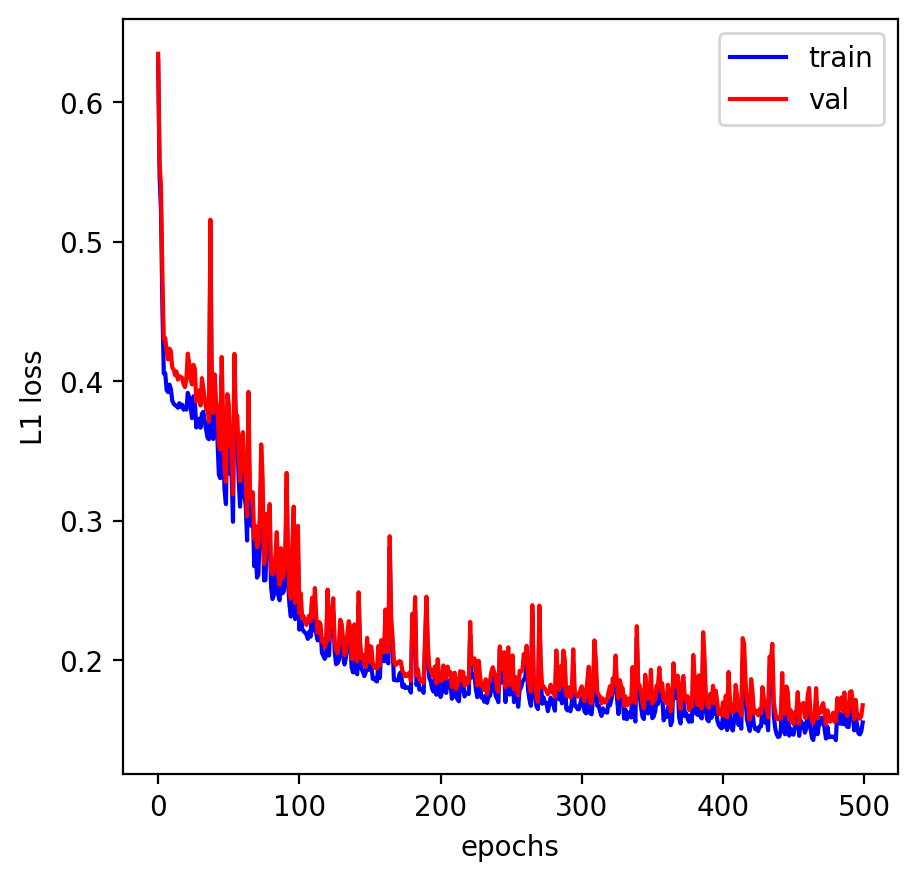

In [102]:
loss_plot(train_l1_list,val_l1_list)

In [103]:
MODEL_PATH = 'model_pyrovae_ECG_sigma_param_epochs_500_latentdim_128_better_train.pth'
torch.save(pyrovae, MODEL_PATH)

In [21]:
import umap.umap_ as umap

def plot_latent_pyro_vea(autoencoder, data,nei):
    stack=[]
    stacky=[]
    for i, d in enumerate(data):
        x=d['sequence']
        y=d['target'].to('cpu').detach().numpy().tolist()
        z,sigma = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        stack.extend([x for x in z])
        stacky.extend(y)
    
    umaper = umap.UMAP(n_components=2,n_neighbors=nei)
    x_umap = umaper.fit_transform(stack)
    plt.scatter(x_umap[:, 0], x_umap[:, 1],s=2, c=stacky, cmap='RdBu')
    plt.colorbar()

In [95]:
def plot_latent_pyro_vea(autoencoder, data,nei):
    stack=[]
    stacky=[]
    for i, d in enumerate(data):
        x=d['sequence']
        y=d['target'].to('cpu').detach().numpy().tolist()
        kee=[]
        for k in range(100):
            z,sigma = autoencoder.encoder(x.to(device))
            z = z.to('cpu').detach().numpy()
            kee.append([r for r in z])
        kee=np.array(kee)
        z = kee.mean(axis=0).tolist()
        stack.extend([x for x in z])
        stacky.extend(y)
    
    umaper = umap.UMAP(n_components=2,n_neighbors=nei)
    x_umap = umaper.fit_transform(stack)
    sc=plt.scatter(x_umap[:, 0], x_umap[:, 1],s=2, c=stacky, cmap='RdBu')
    cb = plt.colorbar(sc,ticks=np.arange(0,2,1))
    cb.ax.tick_params(labelsize=9)
    cb.ax.set_yticklabels(['Normal','Abnormal'])
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

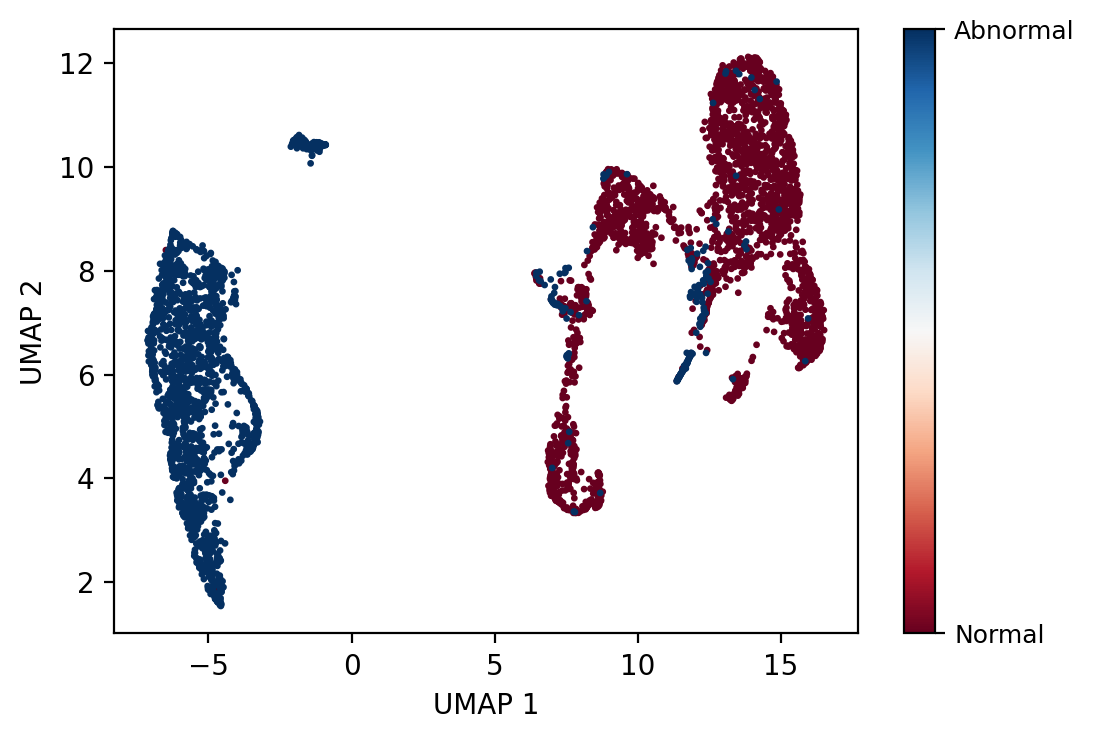

In [96]:
plot_latent_pyro_vea(pyrovae, i_data_loader,100)

To check the kind of ecg I am able to represent, for each initial ecg I am going to draw 100 representations of them 

In [97]:
rec=[]
for i in range(100):
    rec.append(pyrovae.reconstruct_ecg(torch.tensor(train_dataset[:128]).to(device)).detach().to('cpu').numpy())

In [98]:
def ecg_pred(rec,rep,i):
    ecg_sample=np.array([np.array(rec)[k].reshape(128,140,1)[i] for k in range(rep)])
    ecg_std=ecg_sample.std(axis=0)
    ecg_mean=ecg_sample.mean(axis=0)
    zeros_5=torch.tensor(ecg_sample).kthvalue(int(len(ecg_sample) * 0.05), dim=0)[0]
    zeros_95=torch.tensor(ecg_sample).kthvalue(int(len(ecg_sample) * 0.95), dim=0)[0]
    print(zeros_95.shape)
    plt.plot(np.arange(140),ecg_mean,'k',label='mean predict')
    plt.plot(np.arange(140),train_dataset[i].flatten(),'r',label='ground truth')
    plt.fill_between(np.arange(140),
                   [s[0] for s in zeros_5],
                   [s[0] for s in zeros_95],color='orange',
                   alpha=0.9,label='90% CI')
    plt.fill_between(np.arange(140),
                   [m[0]-s[0] for m,s in zip(ecg_mean,ecg_std)],
                   [m[0]+s[0] for m,s in zip(ecg_mean,ecg_std)],
                   alpha=0.5,color='blue',label='std predict')
    
    plt.legend(loc='best',fontsize=10)
    plt.xlabel('t')
    
    plt.show()

torch.Size([140, 1])


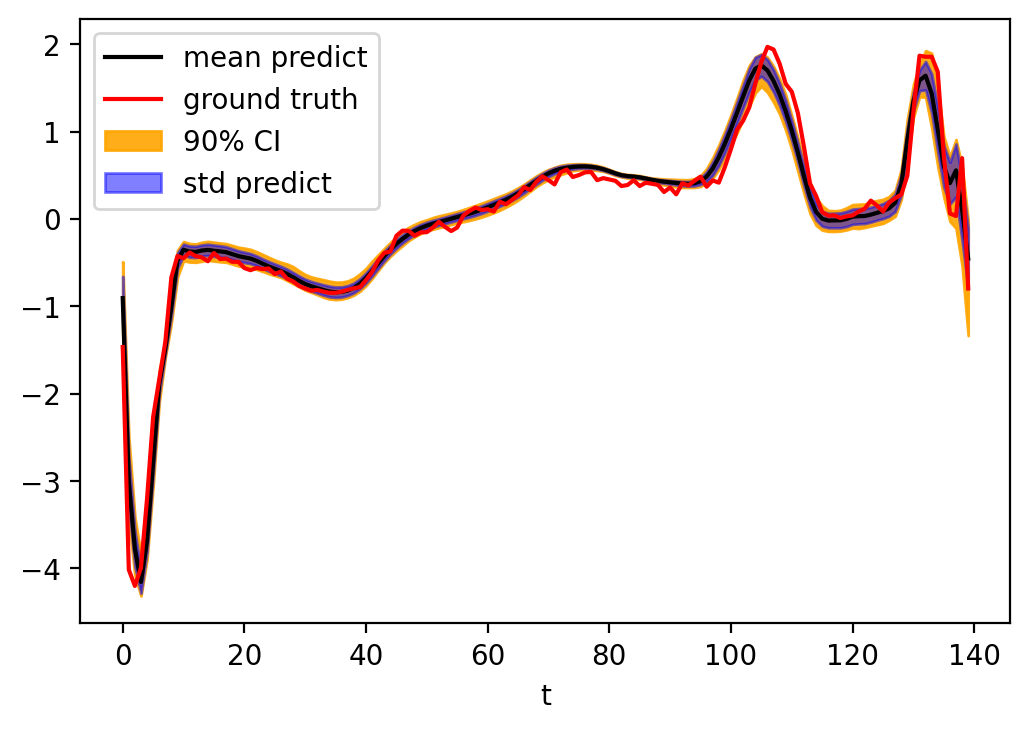

In [99]:
#ECG 11 in normal dataset
ecg_pred(rec,100,10)

torch.Size([140, 1])


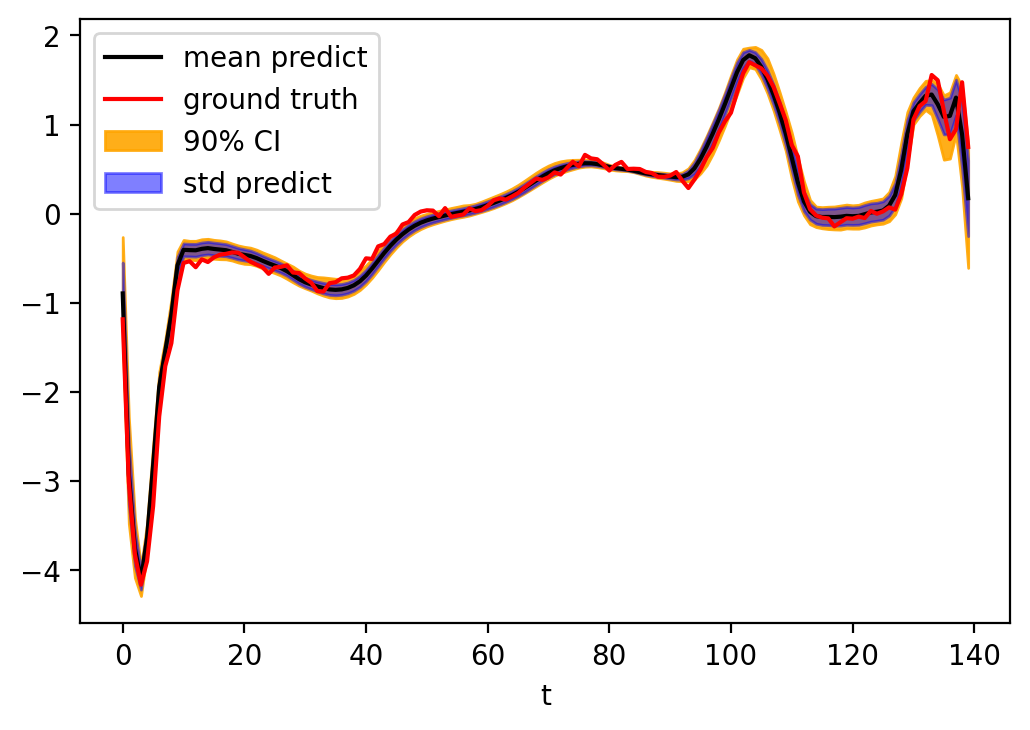

In [100]:
#ECG 51 in normal dataset
ecg_pred(rec,100,50)

In [101]:
pyro.param('sigma')

tensor([0.2464], grad_fn=<AddBackward0>)